---
# Cairo University Faculty of Engineering
## Deep Learning
## Assignment 2

---

Please write your full name here
- **Name** : "Omnia Sayed Sedik"

In [67]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import pandas as pd
import math

from sklearn.datasets import make_blobs  #To generate artificial data
from keras.optimizers import SGD
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

**Use TensorFlow unless mentioned otherwise**

# Part 2: Regression

In this part, (**we will implement the entire linear regression method from scratch,
including the data pipeline, the model,
the loss function, and the minibatch stochastic gradient descent optimizer.**)
You will rely only on tensors and auto differentiation.


we will use $n$ to denote
the number of examples in our dataset.
We index the data examples by $i$, denoting each input
as $\mathbf{x}^{(i)} = [x_1^{(i)}, x_2^{(i)}]^\top$
and the corresponding label as $y^{(i)}$.


**Linear Model**


We will often find it convenient
to refer to features of our entire dataset of $n$ examples
via the *design matrix* $\mathbf{X} \in \mathbb{R}^{n \times d}$.
Here, $\mathbf{X}$ contains one row for every example
and one column for every feature.

For a collection of features $\mathbf{X}$,
the predictions $\hat{\mathbf{y}} \in \mathbb{R}^n$
can be expressed via the matrix-vector product:

$${\hat{\mathbf{y}}} = \mathbf{X} \mathbf{w} + b,$$


**Loss Function**

The most popular loss function in regression problems
is the squared error.
When our prediction for an example $i$ is $\hat{y}^{(i)}$
and the corresponding true label is $y^{(i)}$,
the squared error is given by:

$$l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2.$$


A regression problem for a one-dimensional case is shown below:

<img src="https://i.ibb.co/8cXVC31/fit-linreg.png" alt="fit-linreg" border="0">

To measure the quality of a model on the entire dataset of $n$ examples,
we simply average (or equivalently, sum)
the losses on the training set.

$$L(\mathbf{w}, b) =\frac{1}{n}\sum_{i=1}^n l^{(i)}(\mathbf{w}, b) =\frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

When training the model, we want to find parameters ($\mathbf{w}^*, b^*$)
that minimize the total loss across all training examples:

$$\mathbf{w}^*, b^* = \operatorname*{argmin}_{\mathbf{w}, b}\  L(\mathbf{w}, b).$$


**Minibatch Stochastic Gradient Descent**


The key technique for optimizing models
consists of iteratively reducing the error
by updating the parameters in the direction
that incrementally lowers the loss function --> *gradient descent*.

We will settle for sampling a random minibatch of examples
every time we need to compute the update --> *minibatch stochastic gradient descent*.

We can express the update mathematically as follows
($\partial$ denotes the partial derivative):

$$(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b).$$


## Synthetic Data, Simple Model
### Generating the Dataset

To keep things simple, we will [**construct an artificial dataset
according to a linear model with additive noise.**]

In the following code snippet, we generate a dataset
containing 1000 examples, each consisting of 2 features
sampled from a standard normal distribution.
Thus our synthetic dataset will be a matrix
$\mathbf{X}\in \mathbb{R}^{1000 \times 2}$.

(**The true parameters generating our dataset will be
$\mathbf{w} = [2, -3.4]^\top$ and $b = 4.2$,
and**) our synthetic labels will be assigned according
to the following linear model with the noise term $\epsilon$:

(**$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$**)

In [2]:

def synthetic_data(w, b, num_examples):
    """Generate y = Xw + b + noise."""
    X = tf.zeros((num_examples, w.shape[0]))
    X += tf.random.normal(shape=X.shape)
    y = tf.matmul(X, tf.reshape(w, (-1, 1))) + b
    y += tf.random.normal(shape=y.shape, stddev=0.01)
    y = tf.reshape(y, (-1, 1))
    return X, y

In [3]:
tf.random.set_seed(5)
true_w = tf.constant([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [4]:
print('features:', features[0],'\nlabel:', labels[0])

features: tf.Tensor([-0.18030666 -0.95028627], shape=(2,), dtype=float32) 
label: tf.Tensor([7.0726256], shape=(1,), dtype=float32)


By generating a scatter plot using the second feature `features[:, 1]` and `labels`,
we can clearly observe the linear correlation between the two.


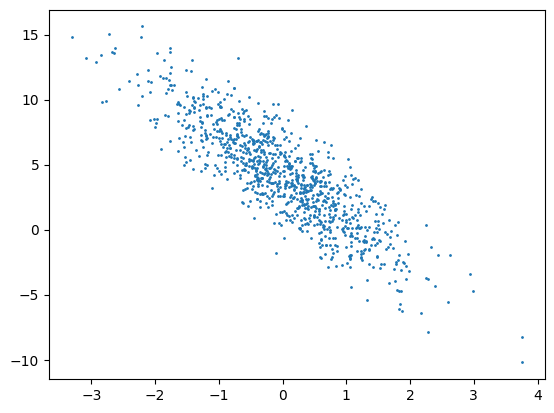

In [5]:
# The semicolon is for displaying the plot only
plt.scatter(features[:, (1)].numpy(), labels.numpy(), 1);

### Reading the Dataset

In the following code [**call upon the existing API in a framework to read data.**]
We pass in `features` and `labels` as arguments and specify `batch_size`
when instantiating a data iterator object.
Besides, the boolean value `is_train`
indicates whether or not
we want the data iterator object to shuffle the data
on each epoch (pass through the dataset).


1. **Use the tf function from_tensor_slices to generate a tf dataset object with batch_size as input**
2. **Use is_train flag to determine whether to shuffle the dataset or not, set the buffer size appropriately**

In [6]:
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a TensorFlow data iterator."""
    #### YOUR CODE HERE ###
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    if is_train:
        buffer_size = len(features)  # Shuffle the entire dataset
        dataset = dataset.shuffle(buffer_size)
    dataset = dataset.batch(batch_size)
    return dataset

In [7]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)
#number of batches
sum(1 for _ in data_iter)

100

3. **Use `iter` to construct a Python iterator and use `next` to obtain the first item from the iterator.**


In [8]:
### YOUR CODE HERE ###
data_iterator = iter(data_iter)
first_batch = next(data_iterator)
first_batch

(<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
 array([[ 0.72162193, -0.04815247],
        [-1.8076526 ,  0.7825731 ],
        [ 1.2142926 ,  0.52065843],
        [-0.5354314 ,  1.3495696 ],
        [-0.1017499 ,  0.21166293],
        [ 0.6335956 , -1.1311781 ],
        [ 0.9409915 ,  1.0605124 ],
        [ 1.0646358 , -0.67903847],
        [-0.5901117 , -0.70856327],
        [-0.31592786, -1.287091  ]], dtype=float32)>,
 <tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[ 5.782361 ],
        [-2.1035023],
        [ 4.8581915],
        [-1.4552264],
        [ 3.2769277],
        [ 9.336542 ],
        [ 2.491425 ],
        [ 8.646172 ],
        [ 5.4147286],
        [ 7.925322 ]], dtype=float32)>)

4. **Explain what the output shape in the prvious tensors means:**


**Answer:**
the tensor consists of a batch sized 10 element where the train consists of two features and the label is ten outputs each represnt one elemnt

5. **How many batches are in the **ENTIRE** data_iter ?**

**Answer:** deviding the total size of the dataset over the batch size will give the data_iter items numbers 1000/10 = 100

### Initializing Model Parameters

6. **Initialize weights by sampling random numbers from a normal distribution with mean 0 and a standard deviation of 0.02, and setting the bias to 0.**

Note: For the shapes of the weights and bias, look at the generating a dataset part


In [9]:
## YOUR CODE HERE ##
w_init = tf.random.normal(shape = (2, 1), mean = 0, stddev = 0.02)
b_init = 0

### Defining the Model

7. [**define our model, relating its inputs and parameters to its outputs.**]

In [10]:
def linreg(X, w, b):
    """
    The linear regression model.
    Input:
    - X: input matrix
    - w: weights
    - bias
    """
    ## YOUR CODE HERE ##
    y_hat = tf.matmult(X, w) + b
    return y_hat

### Defining the Loss Function

8. (**define the loss function**): the squared loss function
as described in Loss Function definition above.

Note: In the implementation, you need to transform the true value `y`
into the predicted value's shape `y_hat`.
The result returned by the following function
will also have the same shape as `y_hat`.


In [11]:
def squared_loss(y_hat, y):
    """Squared loss."""
    ## YOUR CODE HERE ##
    loss = tf.sum(y_hat - y)/len(y)
    return loss

### Defining the Optimization Algorithm

At each step, using one minibatch randomly drawn from our dataset,
we will estimate the gradient of the loss with respect to our parameters.
Next, we will update our parameters
in the direction that may reduce the loss.

9. **Filll in the missing function below to apply the minibatch stochastic gradient descent update, given a set of parameters, a learning rate, and a batch size.**

This function should return nothing

Note: use assign_sub


In [12]:
def sgd(params, grads, lr, batch_size):
    """Minibatch stochastic gradient descent."""
    EPOCHS = 5
    N_BATCHES = 100
    w = params[0]
    b = params[1]
   # Training loop for each epoch
    for epoch in range(EPOCHS):
      # Initialize the epoch loss
      epoch_loss = 0.0
      # Iterate over each batch in the data iterator
      for batch_features, batch_labels in data_iter:
          # Compute the loss
          with tf.GradientTape() as tape:
              predicted_labels = linreg(batch_features, w, b)
              loss_value = squared_loss(predicted_labels, batch_labels)

          # Compute gradients
          gradients = tape.gradient(loss_value, [w, b])

          # Update parameters
          w.assign_sub(lr * grads[0])
          b.assign_sub(lr * grads[1])

          # Accumulate the batch loss
          epoch_loss += loss_value.numpy()

      # Calculate and print the training loss at the end of each epoch
      average_epoch_loss = epoch_loss / len(data_iter)
      print(f"Epoch {epoch+1} Loss: {average_epoch_loss}")



### Training

10. **Implement the following loop**

* For each epoch :
    * For each batch in data_iter:
        * Compute the loss
        * Compute gradient
        * Update parameters
    * Calculate and print the training loss at the end of each epoch



Loss = $ l({x}, {y}) $

Gradient => $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$

Parameters update => $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

In each *epoch*,
we will iterate through the entire dataset
(using the `data_iter` function) once
passing through every example in the training dataset
.

Don't forget to use GradientTape

Set the number of epochs `num_epochs` and the learning rate `lr` to 5 and 0.02, respectively.

In [13]:
lr = 0.02
num_epochs = 5
net = linreg
loss = squared_loss

In [14]:
## YOUR CODE HERE ## The loop code


In this case, because we synthesized the dataset ourselves,
we know precisely what the true parameters are.

11. [**evaluate our success in training by comparing the true parameters with those that we learned through our training loop**] (final w, b). They should turn out to be very close to each other.

calculate the difference!!


In [15]:
## YOUR CODE HERE ##
print(f'error in estimating w: #######')
print(f'error in estimating b: #######')

error in estimating w: #######
error in estimating b: #######


## Diabetes Dataset

In this section, we will use SKLEARN's Diabetes dataset

### Loading the Dataset

1. **Load the Diabetes dataset from sklearn**

In [16]:
from sklearn.datasets import load_diabetes

# Load the diabetes dataset
diabetes = load_diabetes()

2. **Look at the keys of diabetes_dataset dictionary**

In [17]:
## YOUR CODE HERE ##
### Look at keys to determine the data
print(diabetes.keys())

dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module'])


3. **Use the key DESCR to understand the dataset**

In [18]:
## YOUR CODE HERE ##
diabetes.DESCR

'.. _diabetes_dataset:\n\nDiabetes dataset\n----------------\n\nTen baseline variables, age, sex, body mass index, average blood\npressure, and six blood serum measurements were obtained for each of n =\n442 diabetes patients, as well as the response of interest, a\nquantitative measure of disease progression one year after baseline.\n\n**Data Set Characteristics:**\n\n  :Number of Instances: 442\n\n  :Number of Attributes: First 10 columns are numeric predictive values\n\n  :Target: Column 11 is a quantitative measure of disease progression one year after baseline\n\n  :Attribute Information:\n      - age     age in years\n      - sex\n      - bmi     body mass index\n      - bp      average blood pressure\n      - s1      tc, total serum cholesterol\n      - s2      ldl, low-density lipoproteins\n      - s3      hdl, high-density lipoproteins\n      - s4      tch, total cholesterol / HDL\n      - s5      ltg, possibly log of serum triglycerides level\n      - s6      glu, blood sugar

4. **Save the data and target variables in numpy arrays and print their shapes**

In [19]:
### START CODE HERE ### (≈ 2 lines of code)
data = diabetes.data
targets = diabetes.target
### END CODE HERE ###

print ('The shape of data is: ' + str(data.shape))
print ('The shape of targets is: ' + str(targets.shape))
print ('I have f = %d features!' % (data.shape[1]))
print ('I have m = %d examples!' % (data.shape[0]))

The shape of data is: (442, 10)
The shape of targets is: (442,)
I have f = 10 features!
I have m = 442 examples!


5. **What are the ranges of each column in features and the target column?**
    - *Hint* you might find it helpful to convert to pandas dataframe and use ".describe"

In [20]:
### START CODE HERE ###
df = pd.DataFrame(data=diabetes.data, columns=diabetes.feature_names)
df['target'] = diabetes.target
df.describe()
### END CODE HERE ###

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17,3.918434e-17,-5.777179e-18,-9.042540e-18,9.293722e-17,1.130318e-17,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01,346.000000


### Preparing the data

6. **Split the data into train and test set using sklearn train_test_split.** Have the test set as 10% of data

In [21]:
np.random.seed(0)
### START CODE HERE ###
# Split the data into train and test sets
train_data, test_data, train_targets, test_targets = train_test_split(diabetes.data, diabetes.target, test_size=0.1, random_state=0)
train_targets = train_targets.reshape(-1, 1)
test_targets = test_targets.reshape(-1, 1)
### END CODE HERE ###

print("Shape of training data is", train_data.shape)
print("Shape of training targets is", train_targets.shape)
print("Shape of test data is", test_data.shape)
print("Shape of test targets is", test_targets.shape)

Shape of training data is (397, 10)
Shape of training targets is (397, 1)
Shape of test data is (45, 10)
Shape of test targets is (45, 1)


- *feature-wise normalization*: for each feature in the input data (a column in the input data matrix), we subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has a unit standard deviation. This is easily done in NumPy.
- **Question:** Should we normalize features? WHY?
    - ANSWER: it improves the accuracy and convergance of the outliers and that because it improves the influence of outliers if some feature have really large values in comparison with others it may influence the model more so we also want to avoid that.

7. **normalize the targets**

In [22]:
### START CODE HERE ### (≈ 6 lines of code)
from sklearn.preprocessing import StandardScaler
# Create a StandardScaler object
scaler = StandardScaler()
# Fit the scaler to the targets
scaler.fit(train_targets)
# Normalize the targets
y_train_scaled = scaler.transform(train_targets)
y_test_scaled = scaler.transform(test_targets)
### END CODE HERE ###

### Building your model

7. **Use tf.keras.Sequential to build a model with:**
    - 6 hidden layers each having 128 neurons and relu activation.
    - 1 output layer
    - use input_shape argument to specify input size in 1st layer
- **Question:** How many neurons should be in output layer? What should be the activation?
    - ANSWER: the activation function will be linear as it is clear from the data visualization above and the output layer will be only one layer as the target value is continous only one value can output at a time

In [23]:
def build_model(input_shape):
    ### START CODE HERE ### ()
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(input_shape,)),  # Specify input size in the first layer
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')  # Output layer with 2 neurons and sigmoid activation
    ])
    return model

In [24]:
# Print the model summary
# train_data_reshape = train_data.reshape(397, 10, 1)
input_shape=train_data.shape[1]
model = build_model(input_shape)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1408      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dense_6 (Dense)             (None, 1)                 1

8. **Compile the model using optimizer=Adam, loss=mean squared loss, metrics=mean absoluute error:**

In [25]:
### START CODE HERE ### ()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Note that we compile the model with the mse loss function—mean squared error, the
square of the difference between the predictions and the targets. We’re also monitoring a new metric during training: mean absolute error (MAE). It’s the
absolute value of the difference between the predictions and the targets.

9. **FIT the model using for 110 epochs, 64 batch size and a validation split of 0.1**

In [30]:
### START CODE HERE ### ()
history = model.fit(train_data, train_targets, epochs=110, batch_size=64, validation_split=0.1)

Epoch 1/110
6/6 [==============================] - 0s 41ms/step - loss: 2331.8909 - mae: 38.6751 - val_loss: 2906.7029 - val_mae: 42.3811
Epoch 2/110
6/6 [==============================] - 0s 16ms/step - loss: 2335.7681 - mae: 38.7097 - val_loss: 2875.4741 - val_mae: 42.6212
Epoch 3/110
6/6 [==============================] - 0s 16ms/step - loss: 2326.7876 - mae: 38.6597 - val_loss: 2893.7339 - val_mae: 42.3122
Epoch 4/110
6/6 [==============================] - 0s 19ms/step - loss: 2362.9304 - mae: 38.9739 - val_loss: 2899.1106 - val_mae: 43.4939
Epoch 5/110
6/6 [==============================] - 0s 16ms/step - loss: 2385.4927 - mae: 39.1619 - val_loss: 2945.6086 - val_mae: 42.4399
Epoch 6/110
6/6 [==============================] - 0s 22ms/step - loss: 2325.0337 - mae: 38.5713 - val_loss: 2901.0134 - val_mae: 42.9658
Epoch 7/110
6/6 [==============================] - 0s 15ms/step - loss: 2314.7136 - mae: 38.6669 - val_loss: 2956.9055 - val_mae: 42.4336
Epoch 8/110
6/6 [=================

In [31]:
# Evaluate the model on the test set
loss, mae = model.evaluate(test_data, test_targets)
# Print the loss and MAE values
print('Loss:', loss)
print('MAE:', mae)

2/2 [==============================] - 0s 11ms/step - loss: 3780.0544 - mae: 47.1283
Loss: 3780.054443359375
MAE: 47.12825393676758


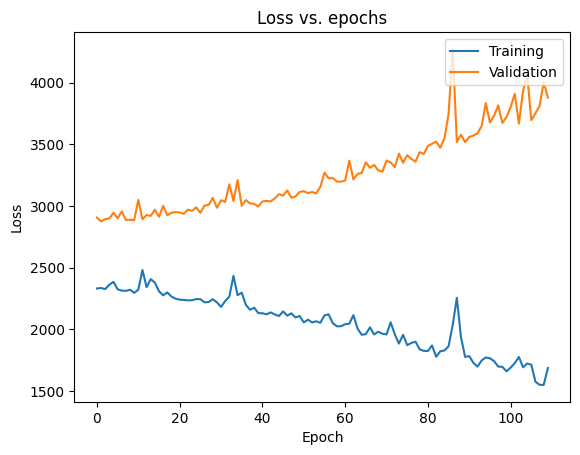

In [32]:
# Plot the training and validation loss
# Get the training and validation loss curves
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot the training and validation loss curves
plt.plot(training_loss, label='Training')
plt.plot(validation_loss, label='Validation')

# Add a title and labels to the plot
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Add a legend to the plot
plt.legend(loc='upper right')

# Show the plot
plt.show()

9. **Diagnose the learning curve:**
    - Why is the validation loss much higher than training loss?
    - What's this phenomenon called?
    - Mention 3 methods to reduce this.

- **answer**:
    - the error is because the model is not able to generaliza after learning the training data vey well due to the many epochs or too many hidden layers or too many neuron in a hidden layer.
    - overfitting
    - early stooping, regularization, data augmantation(increase the size of the data to better teach the model)

10. **Use one of the methods you mentioned and retrain the model then plot the learning curves**

In [33]:
#### YOUR CODE HERE
model_early_stopping = build_model(input_shape)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
model_early_stopping.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_early_stopping.fit(train_data, train_targets, epochs=110, batch_size=64, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/110
6/6 [==============================] - 1s 40ms/step - loss: 28465.0918 - mae: 150.2247 - val_loss: 31315.2930 - val_mae: 155.1729
Epoch 2/110
6/6 [==============================] - 0s 8ms/step - loss: 28411.8379 - mae: 150.0469 - val_loss: 31203.0039 - val_mae: 154.8115
Epoch 3/110
6/6 [==============================] - 0s 10ms/step - loss: 28225.2305 - mae: 149.4175 - val_loss: 30803.1035 - val_mae: 153.5212
Epoch 4/110
6/6 [==============================] - 0s 8ms/step - loss: 27550.7695 - mae: 147.1704 - val_loss: 29396.7930 - val_mae: 148.9122
Epoch 5/110
6/6 [==============================] - 0s 10ms/step - loss: 25257.2051 - mae: 139.2692 - val_loss: 24821.8418 - val_mae: 132.9705
Epoch 6/110
6/6 [==============================] - 0s 8ms/step - loss: 18572.3730 - mae: 113.1445 - val_loss: 13304.0654 - val_mae: 86.8743
Epoch 7/110
6/6 [==============================] - 0s 9ms/step - loss: 7299.4546 - mae: 67.3146 - val_loss: 8038.9307 - val_mae: 77.7360
Epoch 8/110
6/6

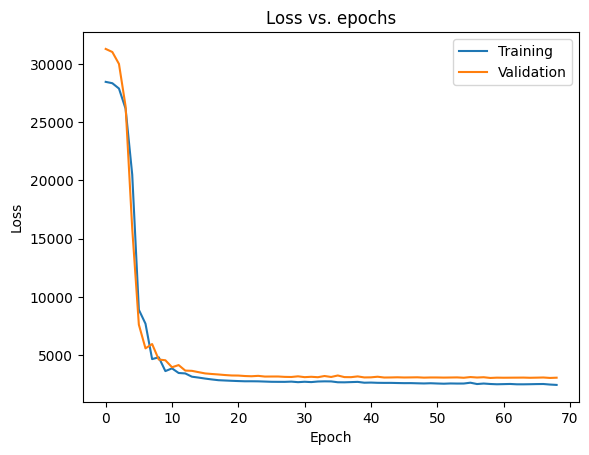

In [ ]:
training_loss = model_early_stopping.history.history['loss']
validation_loss = model_early_stopping.history.history['val_loss']

# Plot the training and validation loss curves
plt.plot(training_loss, label='Training')
plt.plot(validation_loss, label='Validation')

# Add a title and labels to the plot
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Add a legend to the plot
plt.legend(loc='upper right')

# Show the plot
plt.show()

# Part 3 Batches and Epochs

In this part of the assignment we will create a synthetic data to play with.
The data will have 2 features and 3 target classes --> multiclass classification problem

In [68]:
# prepare train and test dataset
def prepare_data():
    #  generate classification dataset with 3 centers (labels/classes)
    X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)

    # plot data
    for class_value in range(3):
        # select indices of points with the class label
        row_ix = np.where(y == class_value)
        # scatter plot for points with a different color
        plt.scatter(X[row_ix, 0], X[row_ix, 1])
    # show plot
    plt.show()

    # one hot encode output variable to convert from integers to binary class
    y = to_categorical(y)

    # split into train and test
    n_train = 500
    X_train, X_test = X[:n_train, :], X[n_train:, :]
    y_train, y_test = y[:n_train], y[n_train:]
    return X_train, y_train, X_test, y_test


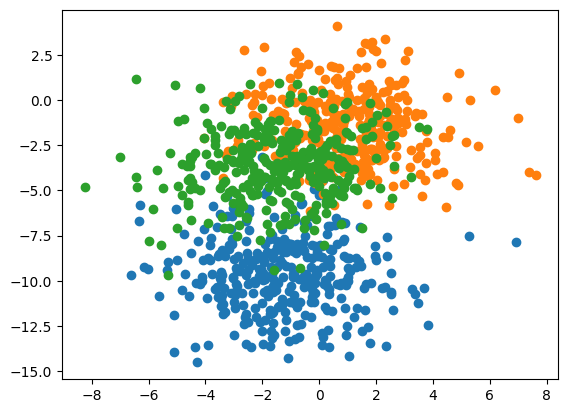

In [69]:
# prepare dataset
X_train, y_train, X_test, y_test = prepare_data()
input_shape = X_train.shape[1]

- **Create a model with:**
    -  1 hidden dense layer (50 neurons), activation relu, , kernel_initializer he_uniform
    - 1 output layer
    - compile the model with SGD (learning rate 0.01 and momentum 0.9) optimizer and categorical crossentropy and accuracy inside build function

In [53]:
def build_model():
    model = tf.keras.Sequential([
      tf.keras.layers.Dense(50, activation='relu', kernel_initializer='he_uniform', input_shape=(input_shape,)),
      tf.keras.layers.Dense(3, activation='sigmoid')
    ])

    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
    # Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

- Create a function to fit and build the model with different batch sizes

Use epochs = 125

In [48]:
# fit a model and plot learning curve
def fit_model(X_train, y_train, X_test, y_test, n_batch, learning_rate):
    ##### YOUR CODE HERE
    model = build_model()
    batch_sizes = X_train.shape[0] // n_batch
    history = model.fit(X_train, y_train, epochs=125, batch_size=batch_sizes, validation_split=0.1)
    model.evaluate(X_test, y_test)
    return history

### Hyperparameter Tuning

#### Batch size

##### Size =  1



10. **train for 1 batch size**

In [49]:
### START CODE HERE ###
batch_size = 1
model_batch_1 = fit_model(X_train, y_train, X_test, y_test, batch_size)
###### END CODE HERE

Epoch 1/125
1/1 [==============================] - 1s 654ms/step - loss: 2.1101 - accuracy: 0.4044 - val_loss: 1.5892 - val_accuracy: 0.4200
Epoch 2/125
1/1 [==============================] - 0s 37ms/step - loss: 1.6222 - accuracy: 0.4133 - val_loss: 1.1157 - val_accuracy: 0.4800
Epoch 3/125
1/1 [==============================] - 0s 37ms/step - loss: 1.2438 - accuracy: 0.4444 - val_loss: 0.9581 - val_accuracy: 0.5000
Epoch 4/125
1/1 [==============================] - 0s 35ms/step - loss: 1.0162 - accuracy: 0.4733 - val_loss: 1.0058 - val_accuracy: 0.4200
Epoch 5/125
1/1 [==============================] - 0s 35ms/step - loss: 0.9897 - accuracy: 0.4933 - val_loss: 0.9521 - val_accuracy: 0.6400
Epoch 6/125
1/1 [==============================] - 0s 36ms/step - loss: 1.1067 - accuracy: 0.5533 - val_loss: 0.8764 - val_accuracy: 0.6600
Epoch 7/125
1/1 [==============================] - 0s 40ms/step - loss: 1.0777 - accuracy: 0.5844 - val_loss: 0.9215 - val_accuracy: 0.4200
Epoch 8/125
1/1 [==

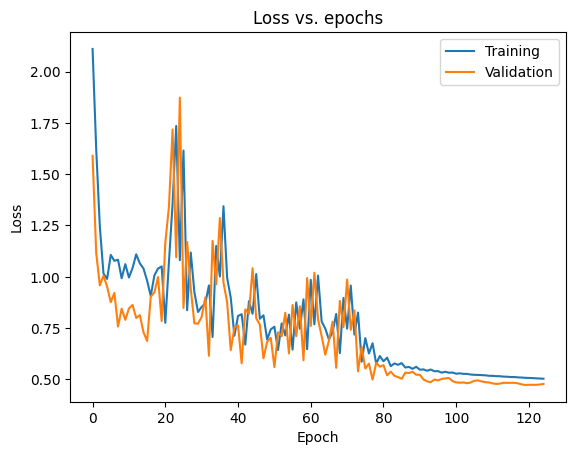

In [51]:
training_loss = model_batch_1.history['loss']
validation_loss = model_batch_1.history['val_loss']

# Plot the training and validation loss curves
plt.plot(training_loss, label='Training')
plt.plot(validation_loss, label='Validation')

# Add a title and labels to the plot
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Add a legend to the plot
plt.legend(loc='upper right')

# Show the plot
plt.show()

- **Diagnose this curve w.r.t learning rate**:
    - ANSWER: the learning rate it 0.01 could be considered big for this problem as the loss flactuates in great amounts
- Change learning rate to make this curve better

In [55]:
def build_model():
    model = tf.keras.Sequential([
      tf.keras.layers.Dense(50, activation='relu', kernel_initializer='he_uniform', input_shape=(input_shape,)),
      tf.keras.layers.Dense(3, activation='sigmoid')
    ])

    optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
    # Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [56]:
model_batch_1_mod_lr = fit_model(X_train, y_train, X_test, y_test, batch_size)

Epoch 1/125
1/1 [==============================] - 1s 729ms/step - loss: 2.9565 - accuracy: 0.2178 - val_loss: 3.0707 - val_accuracy: 0.2400
Epoch 2/125
1/1 [==============================] - 0s 60ms/step - loss: 2.9321 - accuracy: 0.2200 - val_loss: 3.0046 - val_accuracy: 0.2400
Epoch 3/125
1/1 [==============================] - 0s 43ms/step - loss: 2.8867 - accuracy: 0.2156 - val_loss: 2.9131 - val_accuracy: 0.2400
Epoch 4/125
1/1 [==============================] - 0s 58ms/step - loss: 2.8243 - accuracy: 0.2156 - val_loss: 2.8022 - val_accuracy: 0.2600
Epoch 5/125
1/1 [==============================] - 0s 47ms/step - loss: 2.7492 - accuracy: 0.2156 - val_loss: 2.6788 - val_accuracy: 0.2600
Epoch 6/125
1/1 [==============================] - 0s 62ms/step - loss: 2.6665 - accuracy: 0.2200 - val_loss: 2.5505 - val_accuracy: 0.2800
Epoch 7/125
1/1 [==============================] - 0s 63ms/step - loss: 2.5818 - accuracy: 0.2178 - val_loss: 2.4253 - val_accuracy: 0.2800
Epoch 8/125
1/1 [==

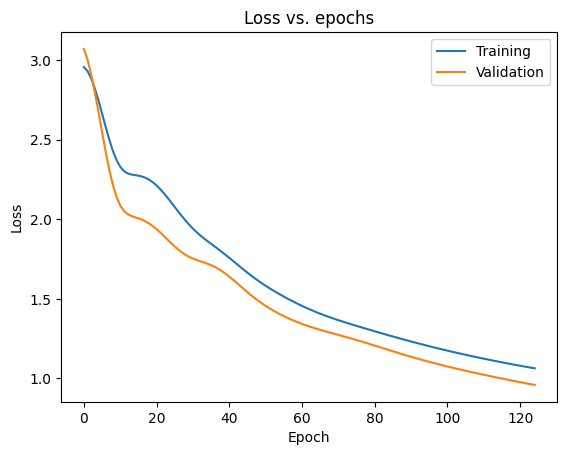

In [57]:
training_loss = model_batch_1_mod_lr.history['loss']
validation_loss = model_batch_1_mod_lr.history['val_loss']

# Plot the training and validation loss curves
plt.plot(training_loss, label='Training')
plt.plot(validation_loss, label='Validation')

# Add a title and labels to the plot
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Add a legend to the plot
plt.legend(loc='upper right')

# Show the plot
plt.show()

##### Size =  16

10. **Retrain for 16 batch size**

In [58]:
### START CODE HERE ###

model_batch_16_mod_lr = fit_model(X_train, y_train, X_test, y_test, 16)

###### END CODE HERE

Epoch 1/125
15/15 [==============================] - 1s 14ms/step - loss: 3.8344 - accuracy: 0.4200 - val_loss: 3.2613 - val_accuracy: 0.4800
Epoch 2/125
15/15 [==============================] - 0s 3ms/step - loss: 2.7872 - accuracy: 0.4311 - val_loss: 2.1689 - val_accuracy: 0.4400
Epoch 3/125
15/15 [==============================] - 0s 5ms/step - loss: 1.8327 - accuracy: 0.3844 - val_loss: 1.5543 - val_accuracy: 0.4200
Epoch 4/125
15/15 [==============================] - 0s 4ms/step - loss: 1.4794 - accuracy: 0.4200 - val_loss: 1.3884 - val_accuracy: 0.3600
Epoch 5/125
15/15 [==============================] - 0s 4ms/step - loss: 1.2912 - accuracy: 0.4467 - val_loss: 1.1903 - val_accuracy: 0.4600
Epoch 6/125
15/15 [==============================] - 0s 5ms/step - loss: 1.1617 - accuracy: 0.4689 - val_loss: 1.0988 - val_accuracy: 0.4600
Epoch 7/125
15/15 [==============================] - 0s 4ms/step - loss: 1.0720 - accuracy: 0.4711 - val_loss: 1.0436 - val_accuracy: 0.4600
Epoch 8/125


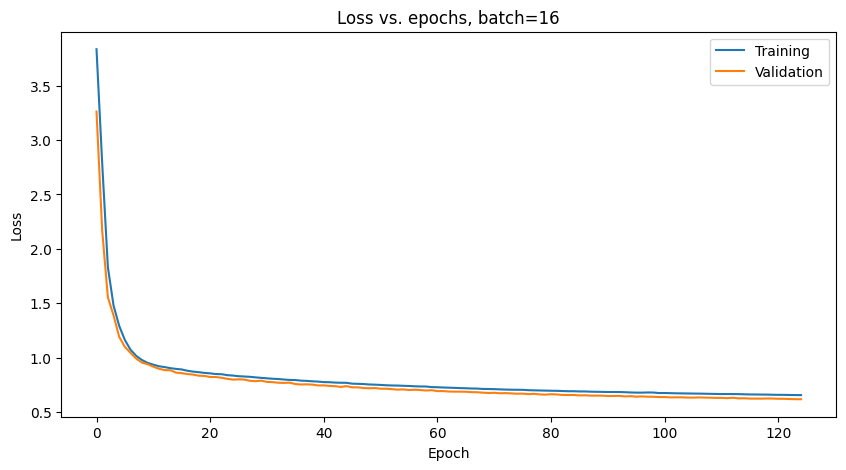

In [59]:
plt.figure(figsize=(10,5))
training_loss = model_batch_16_mod_lr.history['loss']
validation_loss = model_batch_16_mod_lr.history['val_loss']
plt.plot(training_loss, label='Training')
plt.plot(validation_loss, label='Validation')
plt.title('Loss vs. epochs, batch=' +str(16))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

##### Size =  128

10. **Retrain for 128 batch size**

In [63]:
### START CODE HERE ###
model_batch_128_mod_lr = fit_model(X_train, y_train, X_test, y_test, 128)
###### END CODE HERE

Epoch 1/125
150/150 [==============================] - 1s 5ms/step - loss: 1.2321 - accuracy: 0.4511 - val_loss: 0.6955 - val_accuracy: 0.6800
Epoch 2/125
150/150 [==============================] - 1s 4ms/step - loss: 0.8036 - accuracy: 0.6000 - val_loss: 0.7848 - val_accuracy: 0.6400
Epoch 3/125
150/150 [==============================] - 0s 3ms/step - loss: 0.7672 - accuracy: 0.6200 - val_loss: 0.6372 - val_accuracy: 0.6800
Epoch 4/125
150/150 [==============================] - 1s 4ms/step - loss: 0.7589 - accuracy: 0.6289 - val_loss: 0.6349 - val_accuracy: 0.6800
Epoch 5/125
150/150 [==============================] - 1s 3ms/step - loss: 0.7262 - accuracy: 0.6311 - val_loss: 0.6033 - val_accuracy: 0.7000
Epoch 6/125
150/150 [==============================] - 1s 4ms/step - loss: 0.7393 - accuracy: 0.6178 - val_loss: 0.5913 - val_accuracy: 0.7200
Epoch 7/125
150/150 [==============================] - 0s 2ms/step - loss: 0.7184 - accuracy: 0.6378 - val_loss: 0.6169 - val_accuracy: 0.6800

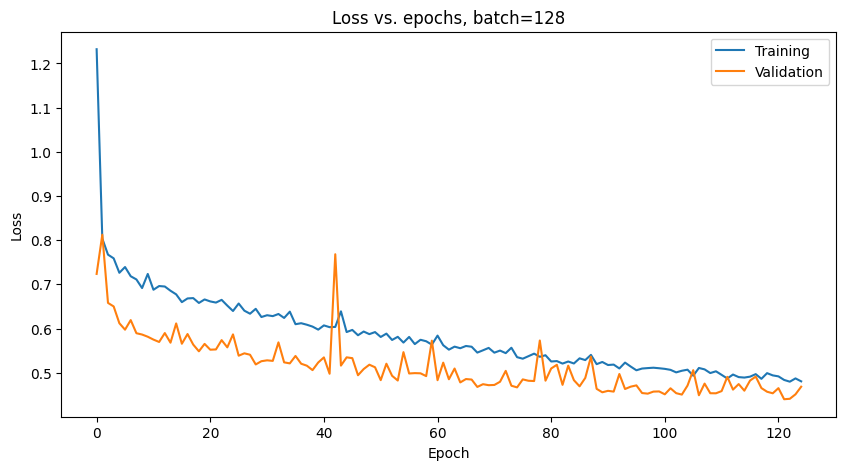

In [64]:
plt.figure(figsize=(10,5))
training_loss = model_batch_128_mod_lr.history['loss']
validation_loss = model_batch_16_mod_lr.history['val_loss']
plt.plot(training_loss, label='Training')
plt.plot(validation_loss, label='Validation')
plt.title('Loss vs. epochs, batch=' +str(128))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

##### Size =  Data

10. **Retrain for length of data batch size**

In [65]:
### START CODE HERE ###
model_batch_397_mod_lr = fit_model(X_train, y_train, X_test, y_test, 397)
###### END CODE HERE

Epoch 1/125
450/450 [==============================] - 1s 2ms/step - loss: 1.3110 - accuracy: 0.4778 - val_loss: 0.6183 - val_accuracy: 0.6800
Epoch 2/125
450/450 [==============================] - 1s 2ms/step - loss: 0.9011 - accuracy: 0.5978 - val_loss: 0.6096 - val_accuracy: 0.6600
Epoch 3/125
450/450 [==============================] - 1s 2ms/step - loss: 0.8312 - accuracy: 0.6111 - val_loss: 0.6378 - val_accuracy: 0.7400
Epoch 4/125
450/450 [==============================] - 1s 2ms/step - loss: 0.7922 - accuracy: 0.6111 - val_loss: 0.7424 - val_accuracy: 0.7200
Epoch 5/125
450/450 [==============================] - 1s 2ms/step - loss: 0.7921 - accuracy: 0.6444 - val_loss: 1.0931 - val_accuracy: 0.6200
Epoch 6/125
450/450 [==============================] - 1s 2ms/step - loss: 0.7778 - accuracy: 0.6533 - val_loss: 0.5336 - val_accuracy: 0.7200
Epoch 7/125
450/450 [==============================] - 1s 2ms/step - loss: 0.7120 - accuracy: 0.6711 - val_loss: 0.5220 - val_accuracy: 0.8000

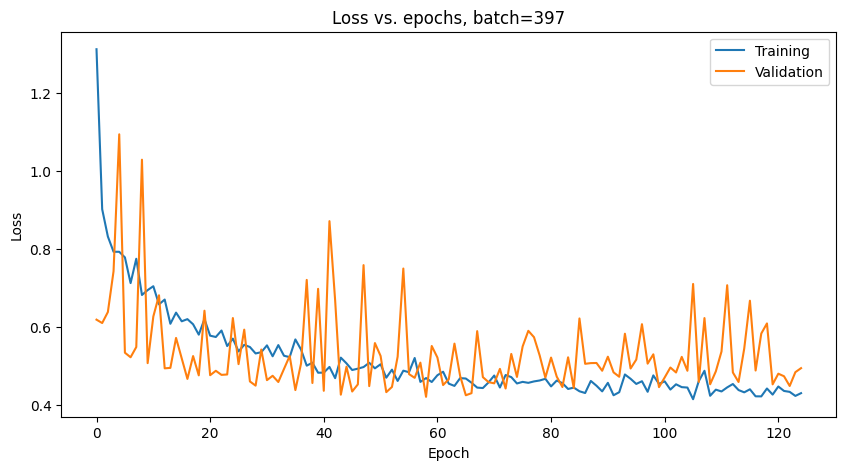

In [66]:
plt.figure(figsize=(10,5))
training_loss = model_batch_397_mod_lr.history['loss']
validation_loss = model_batch_397_mod_lr.history['val_loss']
plt.plot(training_loss, label='Training')
plt.plot(validation_loss, label='Validation')
plt.title('Loss vs. epochs, batch=' +str(397))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

10. **What effect does changing batch size have on learning in terms of convergence and fluctuations?**

**Answer:** the smaller the batch size the better the generalization ability but not too small though because this would lead to overfitting



#### Learning Rate

batch size 64

- **Use same code for build_model above, add an argument learning rate to change learning rate of optmizer**

In [70]:
def build_model(lr):
    model = tf.keras.Sequential([
      tf.keras.layers.Dense(50, activation='relu', kernel_initializer='he_uniform', input_shape=(input_shape,)),
      tf.keras.layers.Dense(3, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
    # Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model
def fit_model(X_train, y_train, X_test, y_test, n_batch, lr):
    ##### YOUR CODE HERE
    model = build_model(lr)
    batch_sizes = X_train.shape[0] // n_batch
    history = model.fit(X_train, y_train, epochs=125, batch_size=batch_sizes, validation_split=0.1)
    model.evaluate(X_test, y_test)
    return history

##### LR =  0.00001

10. **Retrain for 0.00001 LR**

In [72]:
### START CODE HERE ### ()
model_batch_64_mod_lr = fit_model(X_train, y_train, X_test, y_test, 64, 0.00001)

Epoch 1/125
65/65 [==============================] - 1s 7ms/step - loss: 3.4555 - accuracy: 0.3267 - val_loss: 2.9283 - val_accuracy: 0.3800
Epoch 2/125
65/65 [==============================] - 0s 4ms/step - loss: 2.9897 - accuracy: 0.3289 - val_loss: 2.4951 - val_accuracy: 0.3800
Epoch 3/125
65/65 [==============================] - 0s 4ms/step - loss: 2.6091 - accuracy: 0.3267 - val_loss: 2.2136 - val_accuracy: 0.3800
Epoch 4/125
65/65 [==============================] - 0s 3ms/step - loss: 2.3741 - accuracy: 0.3267 - val_loss: 2.0535 - val_accuracy: 0.3600
Epoch 5/125
65/65 [==============================] - 0s 4ms/step - loss: 2.2161 - accuracy: 0.3378 - val_loss: 1.9172 - val_accuracy: 0.3800
Epoch 6/125
65/65 [==============================] - 0s 3ms/step - loss: 2.0781 - accuracy: 0.3444 - val_loss: 1.7947 - val_accuracy: 0.4000
Epoch 7/125
65/65 [==============================] - 0s 2ms/step - loss: 1.9579 - accuracy: 0.3689 - val_loss: 1.6879 - val_accuracy: 0.4000
Epoch 8/125
6

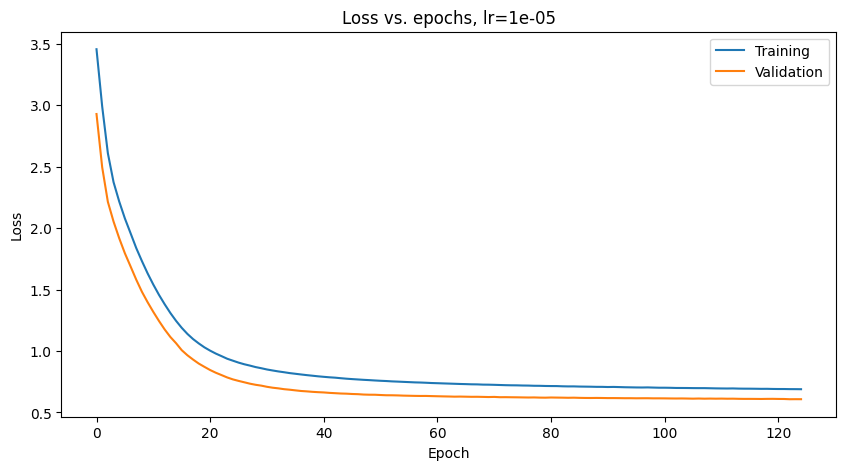

In [73]:
plt.figure(figsize=(10,5))
training_loss = model_batch_64_mod_lr.history['loss']
validation_loss = model_batch_64_mod_lr.history['val_loss']
plt.plot(training_loss, label='Training')
plt.plot(validation_loss, label='Validation')
plt.title('Loss vs. epochs, lr=' +str(0.00001))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

##### LR =  0.001

10. **Retrain for 0.001 LR**

In [75]:
### START CODE HERE ### ()
model_batch_64_lr = fit_model(X_train, y_train, X_test, y_test, 64, 0.0001)

Epoch 1/125
65/65 [==============================] - 1s 5ms/step - loss: 2.1740 - accuracy: 0.3844 - val_loss: 1.0640 - val_accuracy: 0.5400
Epoch 2/125
65/65 [==============================] - 0s 2ms/step - loss: 1.0566 - accuracy: 0.5556 - val_loss: 0.8983 - val_accuracy: 0.5600
Epoch 3/125
65/65 [==============================] - 0s 2ms/step - loss: 0.9738 - accuracy: 0.5800 - val_loss: 0.8589 - val_accuracy: 0.6000
Epoch 4/125
65/65 [==============================] - 0s 2ms/step - loss: 0.9506 - accuracy: 0.5511 - val_loss: 0.8135 - val_accuracy: 0.5400
Epoch 5/125
65/65 [==============================] - 0s 2ms/step - loss: 0.9113 - accuracy: 0.5778 - val_loss: 0.7758 - val_accuracy: 0.5800
Epoch 6/125
65/65 [==============================] - 0s 2ms/step - loss: 0.8971 - accuracy: 0.5689 - val_loss: 0.7781 - val_accuracy: 0.6000
Epoch 7/125
65/65 [==============================] - 0s 2ms/step - loss: 0.8707 - accuracy: 0.5911 - val_loss: 0.7550 - val_accuracy: 0.6400
Epoch 8/125
6

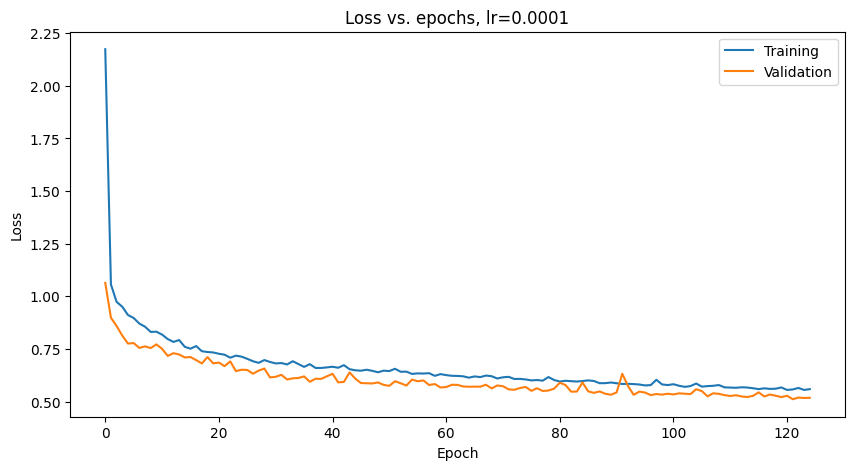

In [77]:
plt.figure(figsize=(10,5))
training_loss = model_batch_64_lr.history['loss']
validation_loss = model_batch_64_lr.history['val_loss']
plt.plot(training_loss, label='Training')
plt.plot(validation_loss, label='Validation')
plt.title('Loss vs. epochs, lr=' +str(0.0001))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

##### LR =  0.1

10. **Retrain for 0.1 LR**

In [78]:
# START CODE HERE ### ()
model_batch_64_lr2 = fit_model(X_train, y_train, X_test, y_test, 64, 0.1)

Epoch 1/125
65/65 [==============================] - 1s 6ms/step - loss: 3.1686 - accuracy: 0.4778 - val_loss: 1.9481 - val_accuracy: 0.5400
Epoch 2/125
65/65 [==============================] - 0s 3ms/step - loss: 1.3961 - accuracy: 0.4733 - val_loss: 2.0903 - val_accuracy: 0.2000
Epoch 3/125
65/65 [==============================] - 0s 3ms/step - loss: 1.1872 - accuracy: 0.4489 - val_loss: 1.5296 - val_accuracy: 0.4000
Epoch 4/125
65/65 [==============================] - 0s 3ms/step - loss: 0.9584 - accuracy: 0.4844 - val_loss: 1.4000 - val_accuracy: 0.5800
Epoch 5/125
65/65 [==============================] - 0s 3ms/step - loss: 0.9845 - accuracy: 0.4533 - val_loss: 1.2058 - val_accuracy: 0.5400
Epoch 6/125
65/65 [==============================] - 0s 2ms/step - loss: 1.0105 - accuracy: 0.4667 - val_loss: 1.7132 - val_accuracy: 0.5200
Epoch 7/125
65/65 [==============================] - 0s 3ms/step - loss: 1.0435 - accuracy: 0.4644 - val_loss: 1.6409 - val_accuracy: 0.5400
Epoch 8/125
6

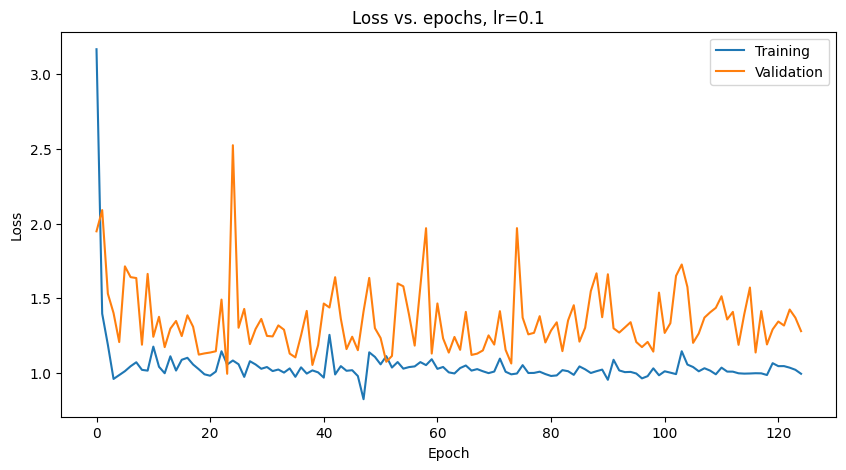

In [79]:
plt.figure(figsize=(10,5))
training_loss = model_batch_64_lr2.history['loss']
validation_loss = model_batch_64_lr2.history['val_loss']
plt.plot(training_loss, label='Training')
plt.plot(validation_loss, label='Validation')
plt.title('Loss vs. epochs, lr=' +str(0.1))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

10. **What effect does changing learning rate have on learning?**





**Answer:** with a suitable batch size increasing the learning rate make the learning flactuates and oscalates greatly

**Questions**

1. Mention 1 advantage of a computational graph?

**Answer:**Computations of the neural network are organized in terms of a forward pass or forward propagation step in which we compute the output of the neural network, followed by a backward pass or backward propagation step, which we use to compute gradients/derivatives. Computation graphs explain why it is organized this way.

2. Mention two ways to input data for training using TensorFlow if the data resides on disk

**Answer:**
1.TensorFlow's tf.data API provides a powerful and efficient way to create data input pipelines
2.Custom Data Loading: Another approach is to implement your own custom data loading mechanism using Python code. In this approach, you would write code to read and preprocess the data from disk using libraries like NumPy, Pandas, or any other suitable libraries for your specific data format.